In [15]:
import os

import pandas as pd

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastpCommandline

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import plotly.express as px

import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('../combined_data.csv')

In [7]:
seqs = []
for i, row in data[data['fold'] != 1].iterrows():
    seqs.append(SeqRecord(row['sequence'], id=row['id'], description=''))

with open('folds2-5.fasta', 'w') as f:
    SeqIO.write(seqs, f, 'fasta')

In [12]:
os.system('../blast/makeblastdb' + ' -in ' + 'folds2-5.fasta' + ' -dbtype prot')



Building a new DB, current time: 12/07/2022 11:58:19
New DB name:   /home/dan/projects/autoimmunity/method2/folds2-5.fasta
New DB title:  folds2-5.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /home/dan/projects/autoimmunity/method2/folds2-5.fasta
Keep MBits: T
Maximum file size: 3000000000B


FASTA-Reader: Ignoring invalid residues at position(s): On line 1569: 8, 18, 40
FASTA-Reader: Ignoring invalid residues at position(s): On line 1570: 31, 41
FASTA-Reader: Ignoring invalid residues at position(s): On line 1571: 3, 54
FASTA-Reader: Ignoring invalid residues at position(s): On line 1572: 4, 26
FASTA-Reader: Ignoring invalid residues at position(s): On line 1574: 1, 15-19, 22, 27, 30-31, 34-35


Adding sequences from FASTA; added 16421 sequences in 0.264981 seconds.




0

In [17]:
blastx_cline = NcbiblastpCommandline(
                cmd='../blast/blastp',
                query = 'fold1.fasta',
                db = 'folds2-5.fasta', 
                evalue=100, outfmt=7, out='fold1_output.csv')

stdout, stderr = blastx_cline()

In [5]:
category_map = dict(zip(data['id'], data['category']))

columns = ['query', 'subject', '%_identity', 'alignment_length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bit_score']

# read in folds
df1 = pd.read_csv('../fold1_output.csv', names=columns)
df2 = pd.read_csv('../fold2_output.csv', names=columns)

# fold 1 
df1['query_category'] = df1['query'].map(category_map)
df1['subject_category'] = df1['subject'].map(category_map)

# fold 2
df2['query_category'] = df2['query'].map(category_map)
df2['subject_category'] = df2['subject'].map(category_map)

In [7]:
# fold 1
idx = df1.groupby('query')['%_identity'].transform(max) == df1['%_identity']
df1 = df1[idx]

df1['result'] = ''

for i, row in df1.iterrows():
    if row['query_category'] == 'autoimmune' and row['subject_category'] == 'autoimmune':
        df1.loc[i, 'result'] = 'TP'
    elif row['query_category'] == 'autoimmune' and row['subject_category'] == 'non_autoimmune':
        df1.loc[i, 'result'] = 'FN'
    elif row['query_category'] == 'non_autoimmune' and row['subject_category'] == 'autoimmune':
        df1.loc[i, 'result'] = 'FP'
    else:
        df1.loc[i, 'result'] = 'TN'

# fold 2
idx = df2.groupby('query')['%_identity'].transform(max) == df2['%_identity']
df2 = df2[idx]

df2['result'] = ''

for i, row in df2.iterrows():
    if row['query_category'] == 'autoimmune' and row['subject_category'] == 'autoimmune':
        df2.loc[i, 'result'] = 'TP'
    elif row['query_category'] == 'autoimmune' and row['subject_category'] == 'non_autoimmune':
        df2.loc[i, 'result'] = 'FN'
    elif row['query_category'] == 'non_autoimmune' and row['subject_category'] == 'autoimmune':
        df2.loc[i, 'result'] = 'FP'
    else:
        df2.loc[i, 'result'] = 'TN'

In [8]:
df1['result'].value_counts()

TN    3758
FP     120
FN      71
TP      11
Name: result, dtype: int64

In [9]:
df2['result'].value_counts()

TN    565787
FN     18978
FP     14330
TP      2918
Name: result, dtype: int64

Text(0.5, 0, 'False Positive Rate')

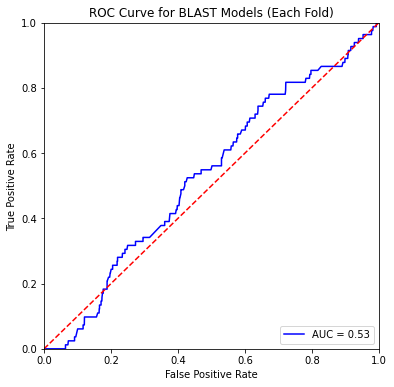

In [18]:
df1['trues'] = df1['query_category'] == 'autoimmune'
df2['trues'] = df2['query_category'] == 'autoimmune'

X = df1['%_identity']
y = df1['trues']

fpr, tpr, thresh = roc_curve(y, X)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('ROC Curve for BLAST Models (Each Fold)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Text(0.5, 0, 'False Positive Rate')

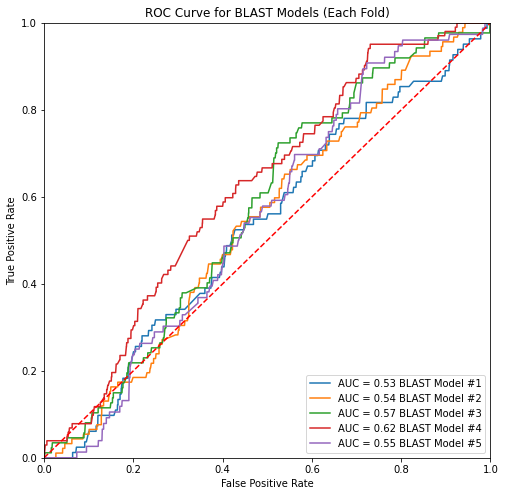

In [27]:
category_map = dict(zip(data['id'], data['category']))
columns = ['query', 'subject', '%_identity', 'alignment_length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bit_score']

plt.figure(figsize=(8,8))

for j in range(1, 6):
    df = pd.read_csv('../fold%i_output.csv' % j, names=columns)
    df['query_category'] = df['query'].map(category_map)
    df['subject_category'] = df['subject'].map(category_map)
    
    idx = df.groupby('query')['%_identity'].transform(max) == df['%_identity']
    df = df[idx]

    df['result'] = ''

    for i, row in df.iterrows():
        if row['query_category'] == 'autoimmune' and row['subject_category'] == 'autoimmune':
            df.loc[i, 'result'] = 'TP'
        elif row['query_category'] == 'autoimmune' and row['subject_category'] == 'non_autoimmune':
            df.loc[i, 'result'] = 'FN'
        elif row['query_category'] == 'non_autoimmune' and row['subject_category'] == 'autoimmune':
            df.loc[i, 'result'] = 'FP'
        else:
            df.loc[i, 'result'] = 'TN'
            
    df['trues'] = df['query_category'] == 'autoimmune'
    
    X = df['%_identity']
    y = df['trues']
    fpr, tpr, thresh = roc_curve(y, X)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label = 'AUC = %0.2f BLAST Model #%i' % (roc_auc, j))
    
plt.title('ROC Curve for BLAST Models (Each Fold)')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')